In [ ]:
!pip install torch torchvision pytorch-lightning wandb seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.9/801.9 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 20.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinu

In [ ]:
!pip install torchinfo

In [ ]:
!mkdir weights

In [ ]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
import yaml
import wandb
from torchvision import transforms
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
from PIL import Image
import os
import seaborn as sns
import torchvision.models as models
import random
from torchinfo import summary
import matplotlib.pyplot as plt

In [ ]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

# Step 1

In this section we load Stanford40 dataset

Split, process it, create torch datasets and dataloaders

Define initial CNN architechture for single image classification

Train the model on Stanford40 dataset
# ---------------------------------------------------------

# Stanford 40 install

In [ ]:
!wget http://vision.stanford.edu/Datasets/Stanford40_JPEGImages.zip
!wget http://vision.stanford.edu/Datasets/Stanford40_ImageSplits.zip

--2024-04-19 19:52:55--  http://vision.stanford.edu/Datasets/Stanford40_JPEGImages.zip
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 304771808 (291M) [application/zip]
Saving to: ‘Stanford40_JPEGImages.zip’

Stanford40_JPEGImag 100%[===================>] 290.65M  8.57MB/s    in 34s     

2024-04-19 19:53:30 (8.57 MB/s) - ‘Stanford40_JPEGImages.zip’ saved [304771808/304771808]

--2024-04-19 19:53:30--  http://vision.stanford.edu/Datasets/Stanford40_ImageSplits.zip
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 62010 (61K) [application/zip]
Saving to: ‘Stanford40_ImageSplits.zip’

Stanford40_ImageSpl 100%[===================>]  60.56K   131KB/s    in 0.5s    

2024-0

In [ ]:
!unzip Stanford40_JPEGImages.zip -d Stanford40/
!unzip Stanford40_ImageSplits.zip -d Stanford40/

Output streaming troncato alle ultime 5000 righe.
  inflating: Stanford40/JPEGImages/phoning_213.jpg  
  inflating: Stanford40/JPEGImages/phoning_214.jpg  
  inflating: Stanford40/JPEGImages/phoning_215.jpg  
  inflating: Stanford40/JPEGImages/phoning_216.jpg  
  inflating: Stanford40/JPEGImages/phoning_217.jpg  
  inflating: Stanford40/JPEGImages/phoning_218.jpg  
  inflating: Stanford40/JPEGImages/phoning_219.jpg  
  inflating: Stanford40/JPEGImages/phoning_220.jpg  
  inflating: Stanford40/JPEGImages/phoning_221.jpg  
  inflating: Stanford40/JPEGImages/phoning_222.jpg  
  inflating: Stanford40/JPEGImages/phoning_223.jpg  
  inflating: Stanford40/JPEGImages/phoning_224.jpg  
  inflating: Stanford40/JPEGImages/phoning_225.jpg  
  inflating: Stanford40/JPEGImages/phoning_226.jpg  
  inflating: Stanford40/JPEGImages/phoning_227.jpg  
  inflating: Stanford40/JPEGImages/phoning_228.jpg  
  inflating: Stanford40/JPEGImages/phoning_229.jpg  
  inflating: Stanford40/JPEGImages/phoning_230.jp

## Read the train and test splits, combine them and make better splits to help training networks easier.

# Stanford40 Data processing

In [ ]:
from collections import Counter
from sklearn.model_selection import train_test_split

keep_stanford40 = ["applauding", "climbing", "drinking", "jumping", "pouring_liquid", "riding_a_bike", "riding_a_horse",
        "running", "shooting_an_arrow", "smoking", "throwing_frisby", "waving_hands"]
with open('Stanford40/ImageSplits/train.txt', 'r') as f:
    # We won't use these splits but split them ourselves
    train_files = [file_name for file_name in list(map(str.strip, f.readlines())) if '_'.join(file_name.split('_')[:-1]) in keep_stanford40]
    train_labels = ['_'.join(name.split('_')[:-1]) for name in train_files]

with open('Stanford40/ImageSplits/test.txt', 'r') as f:
    # We won't use these splits but split them ourselves
    test_files = [file_name for file_name in list(map(str.strip, f.readlines())) if '_'.join(file_name.split('_')[:-1]) in keep_stanford40]
    test_labels = ['_'.join(name.split('_')[:-1]) for name in test_files]

# Combine the splits and split for keeping more images in the training set than the test set.
all_files = train_files + test_files
all_labels = train_labels + test_labels
train_files, test_files = train_test_split(all_files, test_size=0.1, random_state=0, stratify=all_labels)
train_labels = ['_'.join(name.split('_')[:-1]) for name in train_files]
test_labels = ['_'.join(name.split('_')[:-1]) for name in test_files]
print(f'Train files ({len(train_files)}):\n\t{train_files}')
print(f'Train labels ({len(train_labels)}):\n\t{train_labels}\n'\
      f'Train Distribution:{list(Counter(sorted(train_labels)).items())}\n')
print(f'Test files ({len(test_files)}):\n\t{test_files}')
print(f'Test labels ({len(test_labels)}):\n\t{test_labels}\n'\
      f'Test Distribution:{list(Counter(sorted(test_labels)).items())}\n')
action_categories = sorted(list(set(train_labels)))
print(f'Action categories ({len(action_categories)}):\n{action_categories}')

Train files (2733):
	['drinking_203.jpg', 'smoking_048.jpg', 'running_099.jpg', 'jumping_186.jpg', 'smoking_205.jpg', 'riding_a_bike_090.jpg', 'climbing_184.jpg', 'throwing_frisby_078.jpg', 'applauding_185.jpg', 'throwing_frisby_131.jpg', 'running_241.jpg', 'riding_a_horse_229.jpg', 'throwing_frisby_009.jpg', 'climbing_126.jpg', 'waving_hands_188.jpg', 'shooting_an_arrow_062.jpg', 'riding_a_horse_191.jpg', 'applauding_087.jpg', 'applauding_074.jpg', 'riding_a_bike_181.jpg', 'running_091.jpg', 'riding_a_bike_188.jpg', 'riding_a_bike_027.jpg', 'throwing_frisby_035.jpg', 'climbing_022.jpg', 'applauding_095.jpg', 'waving_hands_024.jpg', 'running_225.jpg', 'climbing_224.jpg', 'riding_a_bike_108.jpg', 'running_050.jpg', 'jumping_089.jpg', 'pouring_liquid_089.jpg', 'climbing_087.jpg', 'applauding_143.jpg', 'jumping_069.jpg', 'waving_hands_039.jpg', 'smoking_019.jpg', 'drinking_030.jpg', 'running_189.jpg', 'climbing_159.jpg', 'climbing_221.jpg', 'drinking_162.jpg', 'drinking_210.jpg', 'riding_

### Visualize a photo from the training files and also print its label

An image with the label - drinking


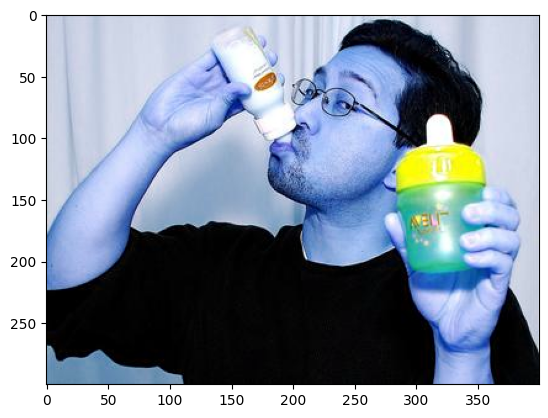

In [ ]:
import cv2

image_no = 70  # change this to a number between [0, 1200] and you can see a different training image
img = cv2.imread(f'Stanford40/JPEGImages/{train_files[image_no]}')
print(f'An image with the label - {train_labels[image_no]}')
plt.imshow(img)

In [ ]:
label_encoder = {
    "applauding": 0, "clap": 0,
    "climbing": 1, "climb": 1,
    "drinking": 2, "drink": 2,
    "jumping": 3, "jump": 3,
    "pouring_liquid": 4, "pour": 4,
    "riding_a_bike": 5, "ride_bike": 5,
    "riding_a_horse": 6, "ride_horse": 6,
    "running": 7, "run": 7,
    "shooting_an_arrow": 8, "shoot_bow": 8,
    "smoking": 9, "smoke": 9,
    "throwing_frisby": 10, "throw": 10,
    "waving_hands": 11, "wave": 11
}

In [ ]:
class img_action_dataset(torch.utils.data.Dataset):
    def __init__(self, data, labels, root_dir='Stanford40/JPEGImages/', transform=None):
        self.data = data
        self.labels = labels
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_id = self.data[idx]
        img = Image.open(os.path.join(self.root_dir, img_id))

        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

In [ ]:
transform = transforms.Compose([
    transforms.Resize(256),              # Resize the image to 256x256 pixels
    transforms.CenterCrop(224),          # Crop the center of the image to make it 224x224 pixels
    transforms.RandomHorizontalFlip(0.5),   # Randomly flip the image horizontally with a default 50% chance
    transforms.ToTensor(),               # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize using ImageNet mean and std
                         std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize(256),              # Resize the image to 256x256 pixels
    transforms.CenterCrop(224),          # Crop the center of the image to make it 224x224 pixels
    transforms.ToTensor(),               # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize using ImageNet mean and std
                         std=[0.229, 0.224, 0.225])
])

In [ ]:
train_labels_enc = [label_encoder[label] for label in train_labels]
test_labels_enc = [label_encoder[label] for label in test_labels]

X_train, X_val, y_train, y_val = train_test_split(train_files, train_labels_enc, test_size=0.1, random_state=0, stratify=train_labels)

# Model 1 (images/frames)

In [ ]:
class ImageClassifier(nn.Module):
    def __init__(self, config):
        super(ImageClassifier, self).__init__()
        self.config = config
        self.body = models.resnet18(pretrained=True)
        self.classifier = [
            nn.Linear(1000, config['hidden_size']),
            nn.BatchNorm1d(config['hidden_size']),
            nn.LeakyReLU(config['leaky_relu_slope']),
            nn.Dropout(config['dropout']),
        ]

        for i in range(config['num_layers'] - 2):
            self.classifier.extend([
                nn.Linear(config['hidden_size'], config['hidden_size']),
                nn.BatchNorm1d(config['hidden_size']),
                nn.LeakyReLU(config['leaky_relu_slope']),
                nn.Dropout(config['dropout']),
            ])

        self.classifier.append(nn.Linear(config['hidden_size'], config['num_classes']))
        self.classifier = nn.Sequential(*self.classifier)


    def forward(self, x):
        x = self.body(x)
        x = self.classifier(x)
        return x


class CNNClassifier(pl.LightningModule):
    def __init__(self, config):
        super(CNNClassifier, self).__init__()
        self.config = config
        if config['model_type'] == 'Spatial':
          self.model = ImageClassifier(config)
        elif config['model_type'] == 'Temporal':
          self.model = TemporalClassifier(config)
        elif config['model_type'] == '2-stream':
          self.model = TwoStreamClassifier(config)

        if self.config['kaiming_init']:
            self.model.apply(self.init_weights)

        self.criterion = nn.CrossEntropyLoss()
        self.learning_rate = config['learning_rate']
        self.batch_size = config['batch_size']
        self.val_progress = []
        self.train_progress = []
        self.test_progress = []
        self.val_loss = 0.0
        self.train_loss = 0.0
        self.best_acc = 0
        self.best_f1 = 0
        self.best_epoch = 0

    def configure_optimizers(self):
        # initialize Adam optimizer and scheduler with warmup
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate, weight_decay=self.config['weight_decay'])
        if self.config['scheduler'] == 'cycle':
            self.scheduler = optim.lr_scheduler.CyclicLR(self.optimizer, base_lr=self.config['min_lr'], max_lr=self.config['max_lr'], step_size_up=self.config['step_size'], cycle_momentum=False)
            return [self.optimizer], [self.scheduler]
        else:
            return [self.optimizer]


    def forward(self, x):
        return self.model(x)


    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_uniform_(m.weight, nonlinearity=self.config['init_nonlinearity'])
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

    def training_step(self, batch, batch_idx):
        x, y = batch
        probs = self(x)
        loss = self.criterion(probs, y)
        self.train_loss += loss.item()
        self.log('train_loss', loss)
        probs = nn.functional.softmax(probs, dim=1)
        self.train_progress.append((probs, y))
        return loss


    def validation_step(self, batch, batch_idx):
        x, y = batch
        probs = self(x)
        loss = self.criterion(probs, y)
        self.val_loss += loss.item()
        self.log('val_loss', loss)
        # save predictions and true labels to calculate accuracy on full validation after epoch end
        probs = nn.functional.softmax(probs, dim=1)
        self.val_progress.append((probs, y))
        return loss

    def on_validation_epoch_end(self):
        # calculate accuracy on full validation set
        preds = torch.cat([pred for pred, y in self.val_progress], dim=0)
        y = torch.cat([y for pred, y in self.val_progress], dim=0)
        preds = torch.argmax(preds, dim=1)
        acc = accuracy_score(y.cpu(), preds.cpu())
        precision, recall, f1, _ = precision_recall_fscore_support(y.cpu(), preds.cpu(), average='macro')

        if len(self.train_progress) > 0:
            train_preds = torch.cat([pred for pred, y in self.train_progress], dim=0)
            train_y = torch.cat([y for pred, y in self.train_progress], dim=0)
            train_preds = torch.argmax(train_preds, dim=1)
            train_acc = accuracy_score(train_y.cpu(), train_preds.cpu())
        else:
            train_acc = 0.0

        # log metrics based on configuration settings
        if self.config['log'] in ['wandb', 'all']:
            log_dict = {'train_loss': self.train_loss, 'train acc': train_acc, 'val_loss': self.val_loss, 'val_acc': acc, 'val_precision': precision, 'val_recall': recall, 'val_f1': f1}
            if self.config['scheduler'] == 'step':
                log_dict['lr'] = self.scheduler.get_last_lr()[0]
            wandb.log(log_dict)
        if self.config['log'] in ['stdout', 'all']:
            print(f'Training loss: {self.train_loss}')
            print(f'Validation accuracy: {acc}')
            print(f'Validation loss: {self.val_loss}')
            print(f'Validation precision: {precision}')
            print(f'Validation recall: {recall}')
            print(f'Validation f1: {f1}')
            if self.config['scheduler'] == 'step':
                print(f'Learning rate: {self.scheduler.get_last_lr()[0]}')

        # saved best model, based on chosen target metric if save_best is set to True
        if self.config['save_best']:
            if self.config['target_metric'] == 'accuracy' and acc >= self.best_acc:
                self.best_acc = acc
                self.save_checkpoint('weights/'+self.config['run_name']+'.pth')
                self.best_epoch = self.current_epoch
                self.best_f1 = f1
            elif self.config['target_metric'] == 'f1' and f1 >= self.best_f1:
                self.best_f1 = f1
                self.save_checkpoint('weights/'+self.config['run_name']+'.pth')
                self.best_epoch = self.current_epoch
                self.best_acc = acc

        # reset variables for next epoch
        self.val_progress = []
        self.val_loss = 0.0
        self.train_loss = 0.0
        self.train_progress = []


    def test_step(self, batch, batch_idx):
        x, y = batch
        probs = self(x)
        loss = self.criterion(probs, y)
        self.log('test_loss', loss)
        probs = nn.functional.softmax(probs, dim=1)
        self.test_progress.append((probs, y))
        return loss

    def on_test_epoch_end(self):
        # calculate accuracy on full test set
        preds = torch.cat([pred for pred, y in self.test_progress], dim=0)
        y = torch.cat([y for pred, y in self.test_progress], dim=0)
        preds = torch.argmax(preds, dim=1)
        acc = accuracy_score(y.cpu(), preds.cpu())
        precision, recall, f1, _ = precision_recall_fscore_support(y.cpu(), preds.cpu(), average='macro')

        # log metrics based on configuration settings
        if self.config['log'] in ['wandb', 'all']:
            wandb.log({'test_acc': acc, 'test_precision': precision, 'test_recall': recall, 'test_f1': f1})
        if self.config['log'] in ['stdout', 'all']:
            print(f'Test accuracy: {acc}')
            print(f'Test precision: {precision}')
            print(f'Test recall: {recall}')
            print(f'Test f1: {f1}')

        # reset variables for next epoch
        self.test_progress = []


    def save_checkpoint(self, path):
        """
        Saves a checkpoint, optimizer, and scheduler from a specified path.
        :param path: The file path from which to load the checkpoint.
        """
        cnn_state = {
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict()
        }
        if self.config['scheduler'] is not None:
            cnn_state['scheduler_state_dict'] = self.scheduler.state_dict()
        torch.save(cnn_state, path)
        wandb.save(path)

    def load_checkpoint(self, path):
        """
        Loads a checkpoint, optimizer, and scheduler from a specified path.
        :param path: The file path from which to load the checkpoint.
        """
        checkpoint = torch.load(path)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        if self.config['scheduler'] is not None:
            self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])



# Experiment 1 (Stanford40 images)

In [ ]:
%%writefile config1.yaml

model_type: Spatial
learning_rate: 0.0001
batch_size: 64
leaky_relu_slope: 0.01
scheduler: cycle
min_lr: 0.0001
max_lr: 0.0005
step_size: 19
weight_decay: 0.01
dropout: 0.24
hidden_size: 256
num_layers: 2
num_classes: 12
save_best: true
target_metric: accuracy
log: wandb
wandb_api_key: c0362c4a4d5eae63102d14065fee9c84ee3d9c8b
epochs: 8
val_check_interval: 1.0
kaiming_init: true
init_nonlinearity: leaky_relu
seed: 42

Writing config1.yaml


In [68]:
with open('config1.yaml', 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

set_seed(config['seed'])

In [ ]:
train_set = img_action_dataset(X_train, y_train, transform=transform)
val_set = img_action_dataset(X_val, y_val, transform=val_test_transform)
test_set = img_action_dataset(test_files, test_labels_enc, transform=val_test_transform)

train_loader = DataLoader(train_set, batch_size=config['batch_size'], shuffle=True)
val_loader = DataLoader(val_set, batch_size=config['batch_size'], shuffle=False)
test_loader = DataLoader(test_set, batch_size=config['batch_size'], shuffle=False)

In [ ]:
wandb.init(project='action_classification', config=config, name='initial-cnn')
wandb.login(key = config['wandb_api_key'])
config['run_name'] = wandb.run.name

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


In [69]:
wandb.init(project='action_classification', config=config, name='initial-cnn')
wandb.login(key = config['wandb_api_key'])
config['run_name'] = wandb.run.name

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


In [ ]:
classifier = CNNClassifier(config)
trainer = pl.Trainer(max_epochs=config['epochs'], check_val_every_n_epoch=1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 136MB/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.uti

In [ ]:
trainer.fit(classifier, train_loader, val_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params
-----------------------------------------------
0 | model     | ImageClassifier  | 11.9 M
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
11.9 M    Trainable params
0         Non-trainable params
11.9 M    Total params
47.797    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (39) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=8` reached.


Run test evaluation (on STanford40 test data) using our final CNN model

In [ ]:
checkpoint = '/content/weights/initial-cnn.pth'
classifier.load_checkpoint(checkpoint)
classifier.config['log'] = 'stdout'

trainer.test(classifier, test_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

Test accuracy: 0.8618421052631579
Test precision: 0.8675228987623566
Test recall: 0.8506551303103027
Test f1: 0.8522540249016398


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.4838426113128662     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.4838426113128662}]

### Model architechture and summary

In [ ]:
classifier

CNNClassifier(
  (model): ImageClassifier(
    (body): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): 

In [ ]:
summary(classifier)

Layer (type:depth-idx)                             Param #
CNNClassifier                                      --
├─ImageClassifier: 1-1                             --
│    └─ResNet: 2-1                                 --
│    │    └─Conv2d: 3-1                            9,408
│    │    └─BatchNorm2d: 3-2                       128
│    │    └─ReLU: 3-3                              --
│    │    └─MaxPool2d: 3-4                         --
│    │    └─Sequential: 3-5                        147,968
│    │    └─Sequential: 3-6                        525,568
│    │    └─Sequential: 3-7                        2,099,712
│    │    └─Sequential: 3-8                        8,393,728
│    │    └─AdaptiveAvgPool2d: 3-9                 --
│    │    └─Linear: 3-10                           513,000
│    └─Sequential: 2-2                             --
│    │    └─Linear: 3-11                           256,256
│    │    └─BatchNorm1d: 3-12                      512
│    │    └─LeakyReLU: 3-13           

# Step 2
In this section we load HMDB51 dataset

Split, process it, create torch dataset and dataloader for middle frames of each sample (each video)

Load pretrained model from previous section and fine-tune it on single-frame HMDB51 dataset
# ---------------------------------------------------------

# Human Motion Database 51 (HMDB51) install

### Extract and organize the data.

In [ ]:
! wget http://serre-lab.clps.brown.edu/wp-content/uploads/2013/10/hmdb51_org.rar
! wget http://serre-lab.clps.brown.edu/wp-content/uploads/2013/10/test_train_splits.rar

--2024-04-19 19:59:38--  http://serre-lab.clps.brown.edu/wp-content/uploads/2013/10/hmdb51_org.rar
Resolving serre-lab.clps.brown.edu (serre-lab.clps.brown.edu)... 128.148.254.114
Connecting to serre-lab.clps.brown.edu (serre-lab.clps.brown.edu)|128.148.254.114|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://serre-lab.clps.brown.edu/wp-content/uploads/2013/10/hmdb51_org.rar [following]
--2024-04-19 19:59:39--  https://serre-lab.clps.brown.edu/wp-content/uploads/2013/10/hmdb51_org.rar
Connecting to serre-lab.clps.brown.edu (serre-lab.clps.brown.edu)|128.148.254.114|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2124008126 (2.0G)
Saving to: ‘hmdb51_org.rar’

hmdb51_org.rar      100%[===================>]   1.98G  33.6MB/s    in 61s     

2024-04-19 20:00:40 (33.1 MB/s) - ‘hmdb51_org.rar’ saved [2124008126/2124008126]

--2024-04-19 20:00:40--  http://serre-lab.clps.brown.edu/wp-content/uploads/2013/10/test_train_splits.rar
R

In [ ]:
! mkdir -p video_data test_train_splits
! unrar e test_train_splits.rar test_train_splits
! rm test_train_splits.rar
! unrar e hmdb51_org.rar
! rm hmdb51_org.rar
! mv *.rar video_data
import os
keep_hmdb51 = ["clap", "climb", "drink", "jump", "pour", "ride_bike", "ride_horse",
        "run", "shoot_bow", "smoke", "throw", "wave"]
for files in os.listdir('video_data'):
    foldername = files.split('.')[0]
    if foldername in keep_hmdb51:
      # extract only the relevant classes for the assignment.
      os.system("mkdir -p video_data/" + foldername)
      os.system("unrar e video_data/"+ files + " video_data/"+foldername)

! rm video_data/*.rar



UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from test_train_splits.rar

Extracting  test_train_splits/brush_hair_test_split1.txt                   0%  OK 
Extracting  test_train_splits/brush_hair_test_split2.txt                   1%  OK 
Extracting  test_train_splits/brush_hair_test_split3.txt                   1%  OK 
Extracting  test_train_splits/cartwheel_test_split1.txt                    2%  OK 
Extracting  test_train_splits/cartwheel_test_split2.txt                    2%  OK 
Extracting  test_train_splits/cartwheel_test_split3.txt                    3%  OK 
Extracting  test_train_splits/catch_test_split1.txt                        4%  OK 
Extracting  test_train_splits/catch_test_split2.txt                        4%  OK 
Extracting  test_train_splits/catch_test_split3.txt                        5%  OK 
Extracting  test_train_splits/chew_test_split1.txt       

# HMDB51 data processing (frames)

### Split the dataset into train and test

In [ ]:
import glob
from collections import Counter
from sklearn.model_selection import train_test_split

TRAIN_TAG, TEST_TAG = 1, 2
train_files, test_files = [], []
train_labels, test_labels = [], []
split_pattern_name = f"*test_split1.txt"
split_pattern_path = os.path.join('test_train_splits', split_pattern_name)
annotation_paths = glob.glob(split_pattern_path)
for filepath in annotation_paths:
    class_name = '_'.join(filepath.split('/')[-1].split('_')[:-2])
    if class_name not in keep_hmdb51:
        continue  # skipping the classes that we won't use.
    with open(filepath) as fid:
        lines = fid.readlines()
    for line in lines:
        video_filename, tag_string = line.split()
        tag = int(tag_string)
        if tag == TRAIN_TAG:
            train_files.append(video_filename)
            train_labels.append(class_name)
        elif tag == TEST_TAG:
            test_files.append(video_filename)
            test_labels.append(class_name)

print(f'Train files ({len(train_files)}):\n\t{train_files}')
print(f'Train labels ({len(train_labels)}):\n\t{train_labels}\n'\
      f'Train Distribution:{list(Counter(sorted(train_labels)).items())}\n')
print(f'Test files ({len(test_files)}):\n\t{test_files}')
print(f'Test labels ({len(test_labels)}):\n\t{test_labels}\n'\
      f'Test Distribution:{list(Counter(sorted(test_labels)).items())}\n')
action_categories = sorted(list(set(train_labels)))
print(f'Action categories ({len(action_categories)}):\n{action_categories}')

Train files (840):
	['A_Beautiful_Mind_5_smoke_u_nm_np1_fr_goo_10.avi', 'After_work_smoke_in_the_garage_smoke_h_nm_np1_fr_bad_0.avi', 'American_History_X_smoke_h_nm_np1_fr_goo_26.avi', 'American_History_X_smoke_h_nm_np1_fr_goo_29.avi', 'American_History_X_smoke_u_nm_np1_fr_med_43.avi', 'Buckle-Up_smoke_h_cm_np1_ri_goo_0.avi', 'Laughing_Girl_smoke_u_nm_np1_ri_goo_0.avi', 'OSSER_-_Qualboro_light_-_Marlboro_Verarschung_smoke_h_cm_np1_le_bad_0.avi', 'Prelinger_LetYours1940_smoke_f_nm_np1_fr_med_6.avi', 'Rauchen_f_r_Anf_nger_smoke_h_nm_np1_fr_med_0.avi', 'Rauchen_f_r_Anf_nger_smoke_h_nm_np1_fr_med_1.avi', 'Rauchen_f_r_Anf_nger_smoke_h_nm_np1_fr_med_2.avi', 'Raucher_Antiraucher_Werbung_smoke_h_cm_np1_fr_goo_2.avi', 'Raucher_Antiraucher_Werbung_smoke_h_cm_np1_fr_med_1.avi', 'Raucher_Antiraucher_Werbung_smoke_u_cm_np1_fr_med_0.avi', 'Return_of_the_King_11_smoke_h_nm_np1_fr_med_0.avi', 'Return_of_the_King_11_smoke_h_nm_np1_fr_med_1.avi', 'Return_of_the_King_1_smoke_h_cm_np1_fr_goo_7.avi', 'Retu

### process

In [ ]:
classname_to_label = {
    "clap": 0,
    "climb": 1,
    "drink": 2,
    "jump": 3,
    "pour": 4,
    "ride_bike": 5,
    "ride_horse": 6,
    "run": 7,
    "shoot_bow": 8,
    "smoke": 9,
    "throw": 10,
    "wave": 11
}

# lets create reverse dict for easy directory retrieval in dataset class: <video_directory>/label_to_classname[label]/filename
label_to_classname = {v:k for k, v in classname_to_label.items()}

In [ ]:
class frame_action_dataset(torch.utils.data.Dataset):
    def __init__(self, data, labels, label_to_classname, root_dir='video_data/', transform=None):
        self.data = data
        self.labels = labels
        self.root_dir = root_dir
        self.transform = transform
        self.label_to_classname = label_to_classname

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        video_file = self.data[idx]  # This should be the name of the AVI file
        label = self.labels[idx]

        video_path = os.path.join(self.root_dir+self.label_to_classname[label]+'/', video_file)

        # Open the video file
        cap = cv.VideoCapture(video_path)
        frame_count = int(cap.get(cv.CAP_PROP_FRAME_COUNT))
        middle_frame_index = frame_count // 2

        # Set frame position
        cap.set(cv.CAP_PROP_POS_FRAMES, middle_frame_index)

        ret, frame = cap.read()  # Read the middle frame
        if not ret:
            print("Failed to read frame from video:", video_path)
            return None, None

        cap.release()  # Release the video capture object

        # Convert the frame, which is in BGR format, to RGB format
        frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)

        # Convert to PIL Image
        img = Image.fromarray(frame)

        if self.transform:
            img = self.transform(img)

        return img, label

In [ ]:
train_labels_enc = [label_encoder[label] for label in train_labels]
test_labels_enc = [label_encoder[label] for label in test_labels]
X_train, X_val, y_train, y_val = train_test_split(train_files, train_labels_enc, test_size=0.1, random_state=0, stratify=train_labels)

# Experiment 2 (single frame classification from pretrained)

In [ ]:
%%writefile config2.yaml

model_type: Spatial
checkpoint: /content/weights/initial-cnn.pth
learning_rate: 0.0001
batch_size: 32
leaky_relu_slope: 0.01
scheduler: cycle
min_lr: 0.0001
max_lr: 0.0005
step_size: 12
weight_decay: 0.01
dropout: 0.24
hidden_size: 256
num_layers: 2
num_classes: 12
save_best: true
target_metric: accuracy
log: wandb
wandb_api_key: c0362c4a4d5eae63102d14065fee9c84ee3d9c8b
epochs: 8
val_check_interval: 1.0
kaiming_init: true
init_nonlinearity: leaky_relu
seed: 42


Writing config2.yaml


In [ ]:
with open('config2.yaml', 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

In [ ]:
train_set = frame_action_dataset(X_train, y_train, label_to_classname, transform=transform)
val_set = frame_action_dataset(X_val, y_val, label_to_classname, transform=val_test_transform)
test_set = frame_action_dataset(test_files, test_labels_enc, label_to_classname, transform=val_test_transform)

train_loader = DataLoader(train_set, batch_size=config['batch_size'], shuffle=True)
val_loader = DataLoader(val_set, batch_size=config['batch_size'], shuffle=False)
test_loader = DataLoader(test_set, batch_size=config['batch_size'], shuffle=False)

In [ ]:
wandb.init(project='action_classification', config=config, name='FINE-TUNING-'+config['checkpoint'].split('/')[-1][:-4])
wandb.login(key = config['wandb_api_key'])
config['run_name'] = wandb.run.name

train acc,▁▅▇██████
train_loss,▁█▃▂▂▁▁▁▂
val_acc,▁███████▇
val_f1,▁▇█████▇▇
val_loss,█▂▂▁▁▁▁▂▄
val_precision,▁██████▇▇
val_recall,▁███████▇
train acc,0.96503
train_loss,5.11309
val_acc,0.72628
val_f1,0.71101


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


In [ ]:
classifier = CNNClassifier(config)
trainer = pl.Trainer(max_epochs=config['epochs'], check_val_every_n_epoch=1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
classifier.configure_optimizers()
classifier.load_checkpoint(config['checkpoint'])

In [ ]:
trainer.fit(classifier, train_loader, val_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params
-----------------------------------------------
0 | model     | ImageClassifier  | 11.9 M
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
11.9 M    Trainable params
0         Non-trainable params
11.9 M    Total params
47.797    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (24) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=8` reached.


Now lets run final fine-tuned version of CNN model on HMDB51 test set

In [ ]:
checkpoint = '/content/weights/FINE-TUNING-initial-cnn.pth'
classifier.load_checkpoint(checkpoint)
classifier.config['log'] = 'stdout'

trainer.test(classifier, test_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

Test accuracy: 0.6027777777777777
Test precision: 0.6276435756503674
Test recall: 0.6027777777777777
Test f1: 0.5931255814311197


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    1.3151419162750244     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.3151419162750244}]

# Step 3
In this section we create HMDB51 optical flow dataset (multiple frames)

Define initial CNN architechture for optical flow classification

Train the model on HMDB51 optical flow dataset
# ---------------------------------------------------------

# HMDB51 data processing (optical flow)

### Extract and save optical flow for all videos

In [ ]:
def extract_and_save_optical_flow(video_path, dir, frames_to_use=16, target_size = (224, 224), center_mode=True, save_dir=None):
    cap = cv.VideoCapture(dir+video_path)
    frame_count = int(cap.get(cv.CAP_PROP_FRAME_COUNT))
    mid_frame = frame_count // 2
    flows = []

    # Determine start frame based on the chosen mode
    if center_mode:
        start_frame = max(mid_frame - frames_to_use // 2, 0)
    else:
        start_frame = max(mid_frame - frames_to_use, 0)

    # Set to the starting frame
    cap.set(cv.CAP_PROP_POS_FRAMES, start_frame)
    ret, prev_frame = cap.read()
    if not ret:
        cap.release()
        return None
    prev_frame = cv2.resize(prev_frame, target_size)
    prev_gray = cv.cvtColor(prev_frame, cv.COLOR_BGR2GRAY)

    for _ in range(frames_to_use):
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, target_size)
        gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
        flow = cv.calcOpticalFlowFarneback(prev_gray, gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
        flows.append(flow)
        prev_gray = gray

    cap.release()

    if len(flows) < frames_to_use:
        print('skipped, num flow frames', len(flows))
        return None  # Handle case where video is too short

    # Stack flow images along the channel dimension
    flow_x = np.stack([flow[..., 0] for flow in flows], axis=2)
    flow_y = np.stack([flow[..., 1] for flow in flows], axis=2)
    stacked_flow = np.concatenate((flow_x, flow_y), axis=2)  # Shape: (H, W, 2*frames_to_use)

    # Optionally save to file
    if save_dir is not None:
        file_name = os.path.basename(video_path).split('.')[0] + '_flow.npy'
        save_path = os.path.join(save_dir, file_name)
        np.save(save_path, stacked_flow)

    return stacked_flow


In [ ]:
!rm -rf flow_data

In [ ]:
# run to create directory for optical flow dataset
!mkdir flow_data
!mkdir flow_data/clap
!mkdir flow_data/climb
!mkdir flow_data/drink
!mkdir flow_data/jump
!mkdir flow_data/pour
!mkdir flow_data/ride_bike
!mkdir flow_data/ride_horse
!mkdir flow_data/run
!mkdir flow_data/shoot_bow
!mkdir flow_data/smoke
!mkdir flow_data/throw
!mkdir flow_data/wave

In [ ]:
# helper function just to get statictics of videos
def get_video_details(video_path):
    # Open the video file
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Error: Could not open video.")
        return None

    # Get the number of frames in the video
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Get the dimensions of the video
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Close the video file
    cap.release()

    return frame_count, frame_width, frame_height

In [ ]:
# only run this once to process and save the optical flows
frames = []
heights = []
widths = []
for dataset, labels in [[X_train, y_train], [X_val, y_val], [test_files, test_labels_enc]]:
  for i, filename in enumerate(dataset):
    dir = 'video_data/'+label_to_classname[labels[i]]+'/'
    save_dir = 'flow_data/'+label_to_classname[labels[i]]+'/'
    stacked_flow = extract_and_save_optical_flow(filename, dir, 16, (224, 224), True, save_dir)
  print('done')


done
done
done


### Optical Flow Dataset

In [ ]:
class OpticalFlowDataset(torch.utils.data.Dataset):
    def __init__(self, video_files, labels, label_to_classname, flow_dir='flow_data/', transform=None):
        self.video_files = video_files
        self.labels = labels
        self.flow_dir = flow_dir
        self.transform = transform
        self.label_to_classname = label_to_classname

    def __len__(self):
        return len(self.video_files)

    def __getitem__(self, idx):
        video_file = self.video_files[idx]
        label = self.labels[idx]

        flow_dir = self.flow_dir + self.label_to_classname[label]+'/'

        flow_file = os.path.join(flow_dir, video_file.split('.')[0] + '_flow.npy')

        # Check if the flow file already exists
        flow = np.load(flow_file)

        # Convert flow data to PIL Image or Tensor here, and apply transformations if any
        flow_tensor = torch.from_numpy(flow).float()  # Ensure it's a float for neural network processing
        flow_tensor = flow_tensor.permute(2, 0, 1)
        if self.transform:
            flow_tensor = self.transform(flow_tensor)
        return flow_tensor, label

# Model 2 (optical flow model)

In [ ]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, ks, stride=1, pooling='max', pooling_ks=2, leaky_relu_slope=0.01):
        super(CNNBlock, self).__init__()
        self.block = [
            nn.Conv2d(in_channels = in_channels, out_channels=out_channels, kernel_size = ks, stride=stride),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(leaky_relu_slope)
        ]
        if pooling == 'max':
            self.block.append(nn.MaxPool2d(kernel_size=pooling_ks))
        elif pooling == 'average':
            self.block.append(nn.AvgPool2d(kernel_size=pooling_ks))

        self.block = nn.Sequential(*self.block)

    def forward(self, x):
        x = self.block(x)
        return x


class TemporalClassifier(nn.Module):
    def __init__(self, config):
        super(TemporalClassifier, self).__init__()
        self.config = config
        self.body = nn.Sequential(*[
            CNNBlock(in_channels = config['num_frames']*2, out_channels = 96, ks = 7, stride=2, pooling='max'),
            CNNBlock(in_channels = 96, out_channels = 256, ks = 5, stride=2, pooling='max'),
            CNNBlock(in_channels = 256, out_channels = 512, ks = 3, stride=1, pooling=''),
            CNNBlock(in_channels = 512, out_channels = 512, ks = 3, stride=1, pooling=''),
            CNNBlock(in_channels = 512, out_channels = 512, ks = 3, stride=1, pooling='max'),
        ])
        self.classifier = [
            nn.Linear(4608, 2048),
            nn.BatchNorm1d(2048),
            nn.LeakyReLU(config['leaky_relu_slope']),
            nn.Dropout(config['dropout']),
            nn.Linear(2048, config['num_classes'])
        ]

        '''for i in range(config['num_layers'] - 2):
            self.classifier.extend([
                nn.Linear(config['hidden_size'], config['hidden_size']),
                nn.BatchNorm1d(config['hidden_size']),
                nn.LeakyReLU(config['leaky_relu_slope']),
                nn.Dropout(config['dropout']),
            ])
        self.classifier.append(nn.Linear(config['hidden_size'], config['num_classes']))'''

        self.classifier = nn.Sequential(*self.classifier)


    def forward(self, x):
        x = self.body(x)
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)
        return x

# Experiment 3 (optical flow training)

In [ ]:
%%writefile config3.yaml

model_type: Temporal
num_frames: 16
learning_rate: 0.0001
batch_size: 32
leaky_relu_slope: 0.01
scheduler: cycle
min_lr: 0.00001
max_lr: 0.0001
step_size: 12
weight_decay: 0.0005
dropout: 0.4
hidden_size: 256
num_layers: 2
num_classes: 12
save_best: true
target_metric: accuracy
log: wandb
wandb_api_key: c0362c4a4d5eae63102d14065fee9c84ee3d9c8b
epochs: 15
val_check_interval: 1.0
kaiming_init: true
init_nonlinearity: leaky_relu
seed: 42

Writing config3.yaml


In [ ]:
with open('config3.yaml', 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

In [ ]:
train_set = OpticalFlowDataset(X_train, y_train, label_to_classname)
val_set = OpticalFlowDataset(X_val, y_val, label_to_classname)
test_set = OpticalFlowDataset(test_files, test_labels_enc, label_to_classname)

train_loader = DataLoader(train_set, batch_size=config['batch_size'], shuffle=True)
val_loader = DataLoader(val_set, batch_size=config['batch_size'], shuffle=False)
test_loader = DataLoader(test_set, batch_size=config['batch_size'], shuffle=False)

In [ ]:
wandb.init(project='action_classification', config=config, name='temporal-cnn')
wandb.login(key = config['wandb_api_key'])
config['run_name'] = wandb.run.name

train acc,▁▅▇██████
train_loss,▁█▃▂▂▁▂▁▂
val_acc,▁▆▇▇█▆█▇▄
val_f1,▁▆▇▇█▆█▆▄
val_loss,▄▂▁▂▂▂▃▂█
val_precision,▁▅▆▇█▇█▆▇
val_recall,▁▅▇▇█▆█▆▃
train acc,0.96693
train_loss,3.09188
val_acc,0.60714
val_f1,0.61245


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


In [ ]:
classifier = CNNClassifier(config)
trainer = pl.Trainer(max_epochs=config['epochs'], check_val_every_n_epoch=1)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [50]:
trainer.fit(classifier, train_loader, val_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type               | Params
-------------------------------------------------
0 | model     | TemporalClassifier | 16.1 M
1 | criterion | CrossEntropyLoss   | 0     
-------------------------------------------------
16.1 M    Trainable params
0         Non-trainable params
16.1 M    Total params
64.547    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (24) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


Now lets run final version of our Temporal CNN on HMDB51 optical flow test set

In [51]:
checkpoint = '/content/weights/temporal-cnn.pth'
classifier.load_checkpoint(checkpoint)
classifier.config['log'] = 'stdout'

trainer.test(classifier, test_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

Test accuracy: 0.24722222222222223
Test precision: 0.2317841007667196
Test recall: 0.24722222222222223
Test f1: 0.22508194079220312


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     2.290827751159668     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 2.290827751159668}]

### Model architechture and summary

In [52]:
classifier

CNNClassifier(
  (model): TemporalClassifier(
    (body): Sequential(
      (0): CNNBlock(
        (block): Sequential(
          (0): Conv2d(32, 96, kernel_size=(7, 7), stride=(2, 2))
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.01)
          (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
      )
      (1): CNNBlock(
        (block): Sequential(
          (0): Conv2d(96, 256, kernel_size=(5, 5), stride=(2, 2))
          (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.01)
          (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
      )
      (2): CNNBlock(
        (block): Sequential(
          (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
          (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running

In [53]:
summary(classifier)

Layer (type:depth-idx)                        Param #
CNNClassifier                                 --
├─TemporalClassifier: 1-1                     --
│    └─Sequential: 2-1                        --
│    │    └─CNNBlock: 3-1                     150,816
│    │    └─CNNBlock: 3-2                     615,168
│    │    └─CNNBlock: 3-3                     1,181,184
│    │    └─CNNBlock: 3-4                     2,360,832
│    │    └─CNNBlock: 3-5                     2,360,832
│    └─Sequential: 2-2                        --
│    │    └─Linear: 3-6                       9,439,232
│    │    └─BatchNorm1d: 3-7                  4,096
│    │    └─LeakyReLU: 3-8                    --
│    │    └─Dropout: 3-9                      --
│    │    └─Linear: 3-10                      24,588
├─CrossEntropyLoss: 1-2                       --
Total params: 16,136,748
Trainable params: 16,136,748
Non-trainable params: 0

# Step 4
In this section we create HMDB51 frame + optical flow dataset (2-stream dataset)

Define 2-stream CNN architechture where we combine 2 previous models and fuse their outputs for final classification

Fine-tune the 2-stream model using the 2 previous checkpoints on HMDB51 frame + optical flow dataset
# ---------------------------------------------------------

# HMDB51 2-stream dataset

In [54]:
class TwoStreamDataset(torch.utils.data.Dataset):
    def __init__(self, video_files, labels, label_to_classname, vid_dir='video_data/', flow_dir='flow_data/', img_transform=None, global_transform=None):
        self.video_files = video_files
        self.labels = labels
        self.flow_dir = flow_dir
        self.vid_dir = vid_dir
        self.img_transform = transform
        self.global_transform = global_transform
        self.label_to_classname = label_to_classname

    def __len__(self):
        return len(self.video_files)

    def __getitem__(self, idx):
        # get image first
        video_file = self.video_files[idx]
        label = self.labels[idx]
        video_path = os.path.join(self.vid_dir+self.label_to_classname[label]+'/', video_file)

        # Open the video file
        cap = cv.VideoCapture(video_path)
        frame_count = int(cap.get(cv.CAP_PROP_FRAME_COUNT))
        middle_frame_index = frame_count // 2

        # Set frame position
        cap.set(cv.CAP_PROP_POS_FRAMES, middle_frame_index)

        ret, frame = cap.read()  # Read the middle frame
        if not ret:
            print("Failed to read frame from video:", video_path)
            return None, None

        cap.release()  # Release the video capture object

        # Convert the frame, which is in BGR format, to RGB format
        frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)

        # Convert to PIL Image
        img = Image.fromarray(frame)
        if self.img_transform:
            img = self.img_transform(img)

        # now get the optical flow

        flow_dir = self.flow_dir + self.label_to_classname[label]+'/'

        flow_file = os.path.join(flow_dir, video_file.split('.')[0] + '_flow.npy')

        # Check if the flow file already exists
        flow = np.load(flow_file)

        # Convert flow data to PIL Image or Tensor here, and apply transformations if any
        flow_tensor = torch.from_numpy(flow).float()  # Ensure it's a float for neural network processing
        flow_tensor = flow_tensor.permute(2, 0, 1)

        return [img, flow_tensor], label

# Model 3 (2-stream model)

In [55]:
class TwoStreamClassifier(nn.Module):
    def __init__(self, config):
        super(TwoStreamClassifier, self).__init__()
        self.config = config
        self.spatial = ImageClassifier(self.config['spatial'])
        self.temporal = TemporalClassifier(self.config['temporal'])

        self.spatial_activation = nn.LeakyReLU(config['leaky_relu_slope'])
        self.temporal_activation = nn.LeakyReLU(config['leaky_relu_slope'])
        self.classifier = [
            nn.Linear(2*config['num_classes'], config['hidden_size']),
            nn.BatchNorm1d(config['hidden_size']),
            nn.LeakyReLU(config['leaky_relu_slope']),
            nn.Dropout(config['dropout']),
        ]

        for i in range(config['num_layers'] - 2):
            self.classifier.extend([
                nn.Linear(config['hidden_size'], config['hidden_size']),
                nn.BatchNorm1d(config['hidden_size']),
                nn.LeakyReLU(config['leaky_relu_slope']),
                nn.Dropout(config['dropout']),
            ])

        self.classifier.append(nn.Linear(config['hidden_size'], config['num_classes']))
        self.classifier = nn.Sequential(*self.classifier)


    def forward(self, x):
        img, flow = x
        x1 = self.spatial_activation(self.spatial(img))
        x2 = self.temporal_activation(self.temporal(flow))
        x = torch.cat((x1, x2), dim=1)
        x = self.classifier(x)
        return x


    def load_checkpoint(self, path, component):
        """
        Loads a checkpoint, optimizer, and scheduler from a specified path.
        :param path: The file path from which to load the checkpoint.
        """
        checkpoint = torch.load(path)
        if component == 'spatial':
          self.spatial.load_state_dict(checkpoint['model_state_dict'])

        if component == 'temporal':
          self.temporal.load_state_dict(checkpoint['model_state_dict'])

# Experiment 4 (2-stream fine-tuning)

In [56]:
%%writefile config4.yaml

model_type: 2-stream
spatial:
  checkpoint: '/content/weights/FINE-TUNING-initial-cnn.pth'
  leaky_relu_slope: 0.01
  hidden_size: 256
  num_layers: 2
  num_classes: 12
  dropout: 0.4
temporal:
  checkpoint: '/content/weights/temporal-cnn.pth'
  num_frames: 16
  leaky_relu_slope: 0.01
  dropout: 0.4
  hidden_size: 256
  num_layers: 2
  num_classes: 12
learning_rate: 0.0001
batch_size: 32
leaky_relu_slope: 0.01
scheduler: cycle
min_lr: 0.0001
max_lr: 0.0005
step_size: 12
weight_decay: 0.0001
dropout: 0.2
hidden_size: 64
num_layers: 2
num_classes: 12
save_best: true
target_metric: accuracy
log: wandb
wandb_api_key: c0362c4a4d5eae63102d14065fee9c84ee3d9c8b
epochs: 15
val_check_interval: 1.0
kaiming_init: true
init_nonlinearity: leaky_relu
seed: 42

Writing config4.yaml


In [57]:
with open('config4.yaml', 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

set_seed(config['seed'])

In [58]:
img_transform = transforms.Compose([
    transforms.Resize(256),              # Resize the image to 256x256 pixels
    transforms.CenterCrop(224),          # Crop the center of the image to make it 224x224 pixels
    transforms.ToTensor(),               # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize using ImageNet mean and std
                         std=[0.229, 0.224, 0.225])
])

In [59]:
train_set = TwoStreamDataset(X_train, y_train, label_to_classname, img_transform=img_transform)
val_set = TwoStreamDataset(X_val, y_val, label_to_classname, img_transform=img_transform)
test_set = TwoStreamDataset(test_files, test_labels_enc, label_to_classname, img_transform=img_transform)

train_loader = DataLoader(train_set, batch_size=config['batch_size'], shuffle=True)
val_loader = DataLoader(val_set, batch_size=config['batch_size'], shuffle=False)
test_loader = DataLoader(test_set, batch_size=config['batch_size'], shuffle=False)

In [60]:
wandb.init(project='action_classification', config=config, name='2-stream-cnn')
wandb.login(key = config['wandb_api_key'])
config['run_name'] = wandb.run.name

train acc,▁▂▃▄▅▆▆▇▇▇▇▇████
train_loss,▁█▆▅▅▄▄▃▃▃▃▂▂▂▂▂
val_acc,▁▃▄▇▇▇▇█▆▆▇▆▇▆▄▅
val_f1,▁▃▄▇▇█▇█▇▆█▆█▆▅▆
val_loss,▁█▆▆▆▅▅▅▆▅▅▇▅▇▇█
val_precision,▁▄▄▇█▇▇█▇▆█▆█▆▅▅
val_recall,▁▃▄▇▇▇▇█▆▆▇▆▇▆▄▅
train acc,0.91667
train_loss,7.32567
val_acc,0.2381
val_f1,0.22392


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


In [61]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classifier = CNNClassifier(config).to(device)
trainer = pl.Trainer(max_epochs=config['epochs'], check_val_every_n_epoch=1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [62]:
classifier.configure_optimizers()
classifier.model.load_checkpoint(config['spatial']['checkpoint'], component='spatial')
classifier.model.load_checkpoint(config['temporal']['checkpoint'], component='temporal')

In [63]:
trainer.fit(classifier, train_loader, val_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                | Params
--------------------------------------------------
0 | model     | TwoStreamClassifier | 28.1 M
1 | criterion | CrossEntropyLoss    | 0     
--------------------------------------------------
28.1 M    Trainable params
0         Non-trainable params
28.1 M    Total params
112.354   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (24) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


Finally lets evaluate our fine-tuned 2-stream CNN model on HMDB51 Two-Stream test dataset

In [64]:
checkpoint = '/content/weights/2-stream-cnn.pth'
classifier.load_checkpoint(checkpoint)
classifier.config['log'] = 'stdout'

trainer.test(classifier, test_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

Test accuracy: 0.475
Test precision: 0.5244065429395309
Test recall: 0.47500000000000003
Test f1: 0.454747274390829


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    1.7224829196929932     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.7224829196929932}]

### Model architechture and summary

In [ ]:
classifier

In [66]:
summary(classifier)

Layer (type:depth-idx)                                  Param #
CNNClassifier                                           --
├─TwoStreamClassifier: 1-1                              --
│    └─ImageClassifier: 2-1                             --
│    │    └─ResNet: 3-1                                 11,689,512
│    │    └─Sequential: 3-2                             259,852
│    └─TemporalClassifier: 2-2                          --
│    │    └─Sequential: 3-3                             6,668,832
│    │    └─Sequential: 3-4                             9,467,916
│    └─LeakyReLU: 2-3                                   --
│    └─LeakyReLU: 2-4                                   --
│    └─Sequential: 2-5                                  --
│    │    └─Linear: 3-5                                 1,600
│    │    └─BatchNorm1d: 3-6                            128
│    │    └─LeakyReLU: 3-7                              --
│    │    └─Dropout: 3-8                                --
│    │    └─Linear: 

Layer (type:depth-idx)                                  Param #
CNNClassifier                                           --
├─TwoStreamClassifier: 1-1                              --
│    └─ImageClassifier: 2-1                             --
│    │    └─ResNet: 3-1                                 11,689,512
│    │    └─Sequential: 3-2                             259,852
│    └─TemporalClassifier: 2-2                          --
│    │    └─Sequential: 3-3                             6,668,832
│    │    └─Sequential: 3-4                             9,467,916
│    └─LeakyReLU: 2-3                                   --
│    └─LeakyReLU: 2-4                                   --
│    └─Sequential: 2-5                                  --
│    │    └─Linear: 3-5                                 1,600
│    │    └─BatchNorm1d: 3-6                            128
│    │    └─LeakyReLU: 3-7                              --
│    │    └─Dropout: 3-8                                --
│    │    └─Linear: 